### Solving an Image Classification Problem using PyTorch

In [1]:
from keras.datasets import fashion_mnist

In [2]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

In [3]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Visualizing the Images

In [4]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
# from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

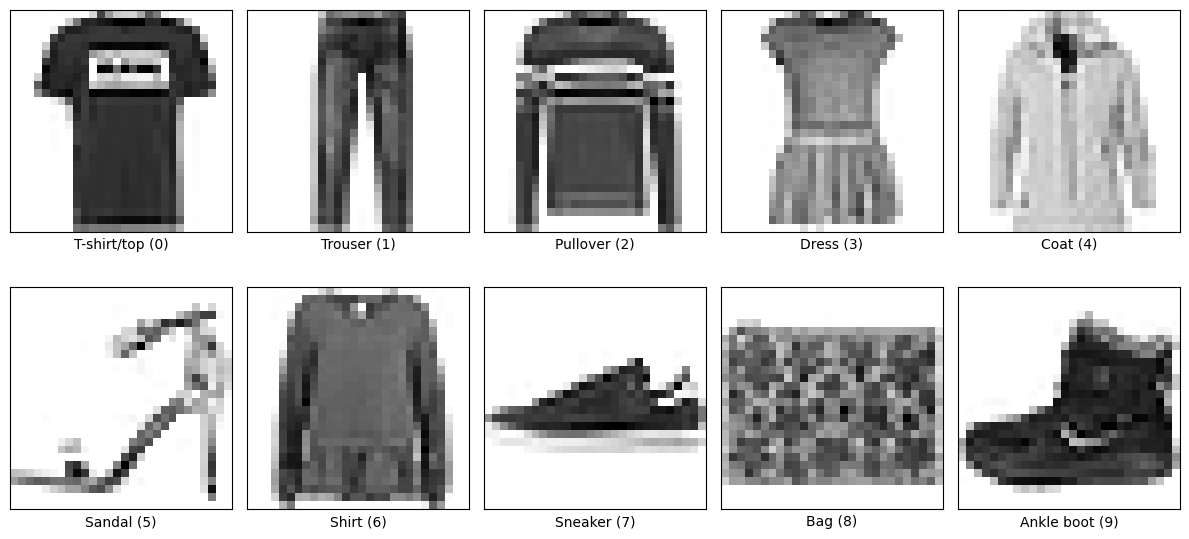

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define class labels for Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Initialize an array to keep track of which class indices have been displayed
class_indices_displayed = np.zeros(len(class_names), dtype=bool)

# Display one sample image from each class along with label and index
plt.figure(figsize=(12, 6))
for i in range(len(trainY)):
    label_index = trainY[i]
    if not class_indices_displayed[label_index]:
        plt.subplot(2, 5, label_index + 1)
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.grid(False)  # Disable grid lines
        plt.imshow(trainX[i], cmap=plt.cm.binary)  # Display image
        plt.xlabel(f"{class_names[label_index]} ({label_index})")  # Set label for x-axis
        class_indices_displayed[label_index] = True  # Mark class index as displayed
    if np.all(class_indices_displayed):  # Break loop if all classes have been displayed
        break
plt.tight_layout()
plt.show()


### Create validation set and preprocessing the images 

In [6]:
train_x, val_x, train_y, val_y = train_test_split(trainX, trainY, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [7]:
# converting training images into torch format
train_x = train_x.reshape(54000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([54000, 1, 28, 28]), torch.Size([54000]))

In [8]:
# converting validation images into torch format
val_x = val_x.reshape(6000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

### CNN Model

In [9]:
## Architecture

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=2, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=2, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

#### Let's now call the model, and define the optimizer and the loss function for the model 

In [10]:
# define the model
model = Net()
# define the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [23]:
## function to train the model

def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    x_train = x_train.float()
    x_val = x_val.float()
    output_train = model(x_train)
    output_val = model(x_val)

    # Ensure that target tensors are of type torch.LongTensor
    y_train = y_train.long()
    y_val = y_val.long()

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    #if epoch%2 == 0:
        # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [12]:
#Reshaping and Conversion
test_x = testX.reshape(10000, 1, 28, 28)
test_x  = torch.from_numpy(test_x)

C:\Users\matti\AppData\Local\Temp\ipykernel_21356\1933559697.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  test_x  = torch.from_numpy(test_x)


In [13]:
# generating predictions for test set
with torch.no_grad():
    test_x = test_x.float()
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

In [14]:
test_y = testY.astype(int);
test_y = torch.from_numpy(test_y)

Epoch :  1 	 loss : tensor(2.4372, grad_fn=<NllLossBackward0>)
Epoch :  2 	 loss : tensor(5.4951, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(5.3855, grad_fn=<NllLossBackward0>)
Epoch :  4 	 loss : tensor(3.6245, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(2.7471, grad_fn=<NllLossBackward0>)
Epoch :  6 	 loss : tensor(1.9631, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(1.7792, grad_fn=<NllLossBackward0>)
Epoch :  8 	 loss : tensor(1.8452, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(1.8873, grad_fn=<NllLossBackward0>)
Epoch :  10 	 loss : tensor(1.9109, grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(1.8915, grad_fn=<NllLossBackward0>)
Epoch :  12 	 loss : tensor(1.8413, grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(1.7350, grad_fn=<NllLossBackward0>)
Epoch :  14 	 loss : tensor(1.5871, grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(1.4790, grad_fn=<NllLossBackward0>)
Epoch :  16 	 loss : tensor(1.3805, grad_fn=<NllL

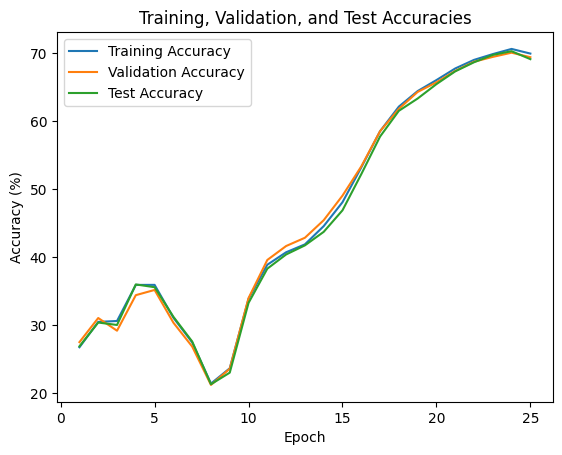

In [15]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []


# Empty lists to store training, validation, and test accuracies
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training the model
for epoch in range(n_epochs):
    train(epoch)
    
    # Predictions for the training set
    with torch.no_grad():
        train_x = train_x.float()
        output = model(train_x)
    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    # Accuracy on the training set
    training_accuracy = accuracy_score(train_y, predictions)
    train_accuracies.append(training_accuracy)

    # Predictions for the validation set
    with torch.no_grad():
        val_x = val_x.float()
        output = model(val_x)
    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    # Accuracy on the validation set
    validation_accuracy = accuracy_score(val_y, predictions)
    val_accuracies.append(validation_accuracy)

    # Predictions for the test set
    with torch.no_grad():
        test_x = test_x.float()
        output = model(test_x)
    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    # Accuracy on the test set
    test_accuracy = accuracy_score(test_y, predictions)
    test_accuracies.append(test_accuracy)

# Convert accuracies to percentages
train_accuracies_percent = [accuracy * 100 for accuracy in train_accuracies]
val_accuracies_percent = [accuracy * 100 for accuracy in val_accuracies]
test_accuracies_percent = [accuracy * 100 for accuracy in test_accuracies]

# Plotting the accuracies
plt.plot(range(1, n_epochs+1), train_accuracies_percent, label='Training Accuracy')
plt.plot(range(1, n_epochs+1), val_accuracies_percent, label='Validation Accuracy')
plt.plot(range(1, n_epochs+1), test_accuracies_percent, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracies')
plt.legend()
plt.show()



In [20]:
# Predictions for the training set
with torch.no_grad():
    train_x = train_x.float()
    output = model(train_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# Accuracy on the training set
training_accuracy = accuracy_score(train_y, predictions)
training_accuracy_percent = training_accuracy * 100
print(f"Accuracy on the training set: {training_accuracy_percent:.2f}%")


Accuracy on the training set: 69.97%


In [21]:
# Predictions for the validation set
with torch.no_grad():
    val_x = val_x.float()
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# Accuracy on the validation set
validation_accuracy = accuracy_score(val_y, predictions)
validation_accuracy_percent = validation_accuracy * 100
print(f"Accuracy on the validation set: {validation_accuracy_percent:.2f}%")


Accuracy on the validation set: 69.43%


In [22]:
# Predictions for the test set
with torch.no_grad():
    test_x = test_x.float()
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

test_y = testY.astype(int)
test_y_tensor = torch.from_numpy(test_y)

# Accuracy on the test set
test_accuracy = accuracy_score(test_y_tensor, predictions)
test_accuracy_percent = test_accuracy * 100
print(f"Accuracy on the test set: {test_accuracy_percent:.2f}%")


Accuracy on the test set: 69.15%


Display of sample images with predictions and actual labels

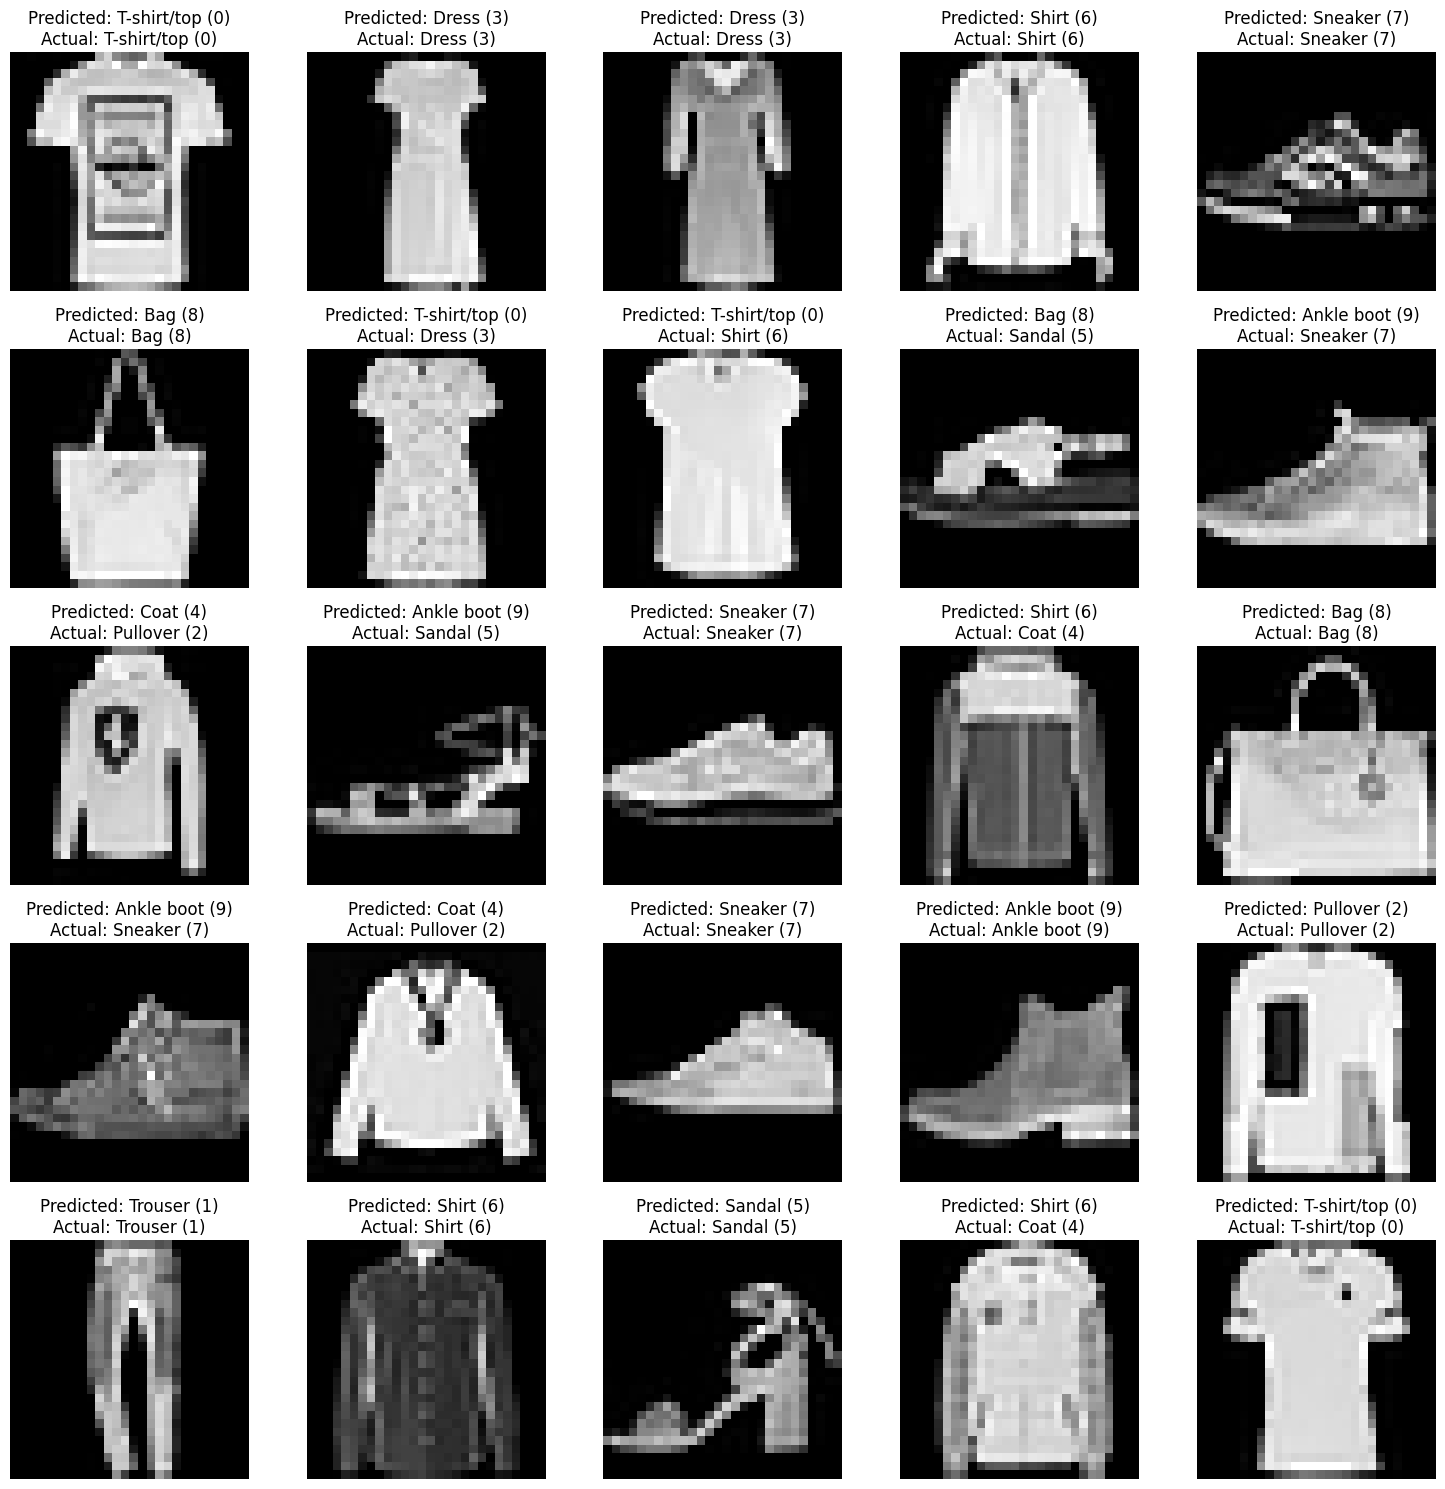

In [19]:
# Define a function to display sample images with predictions and actual labels
def display_sample_images(images, predictions, actual_labels, class_names, num_images=25):
    num_cols = 5  # Number of columns in the grid
    num_rows = (num_images + num_cols - 1) // num_cols  # Number of rows in the grid

    plt.figure(figsize=(15, 15))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        # Remove the extra dimension from the image data
        image = np.squeeze(images[i])
        plt.imshow(image, cmap='gray')  # Display the image
        # Display both predicted and actual labels
        predicted_label = predictions[i]
        actual_label = actual_labels[i]
        plt.title(f"Predicted: {class_names[predicted_label]} ({predicted_label})\nActual: {class_names[actual_label]} ({actual_label})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select a random sample of 25 images and their corresponding predictions and actual labels
num_images_to_display = 25
indices = np.random.choice(len(test_x), num_images_to_display, replace=False)
sample_images = [test_x[i] for i in indices]
sample_predictions = [predictions[i] for i in indices]
sample_actual_labels = [test_y[i] for i in indices]

# Assuming you have a list of class names like this
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display the sample of images with predictions and actual labels
display_sample_images(sample_images, sample_predictions, sample_actual_labels, class_names, num_images_to_display)
